In [25]:
import os
os.listdir('../../data/kaggle-histopathologic-cancer-detection/data/')

['test', 'sample_submission.csv', 'train', 'train_labels.csv']

In [26]:
base_dir = '../../data/kaggle-histopathologic-cancer-detection/data/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

print('Length of train_dir:', len(os.listdir(train_dir)))
print('Length of test_dir:', len(os.listdir(test_dir)))

Length of train_dir: 220025
Length of test_dir: 57458


In [27]:
# Chose a not-totally-arbitrary arbitrary random state
RANDOM_STATE = 62

In [28]:
import pandas as pd

labels_df = pd.read_csv(os.path.join(base_dir, 'train_labels.csv'))
print('Head:', labels_df.head())
print('labels_df shape:', labels_df.shape)
print('Unique labels:', labels_df.label.unique())

Head:                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
labels_df shape: (220025, 2)
Unique labels: [0 1]


The label values we have are 0 and 1

A **1** indicates that there is at least one pixel of tumor tissue exists in the center 32x32 region of the input image

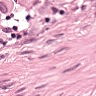

117971    1
Name: label, dtype: int64


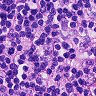

99147    0
Name: label, dtype: int64


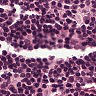

44862    0
Name: label, dtype: int64


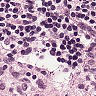

59469    0
Name: label, dtype: int64


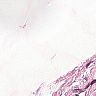

197168    0
Name: label, dtype: int64


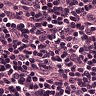

81795    0
Name: label, dtype: int64


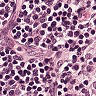

210486    0
Name: label, dtype: int64


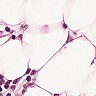

168294    1
Name: label, dtype: int64


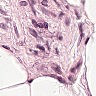

91828    0
Name: label, dtype: int64


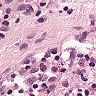

53118    1
Name: label, dtype: int64


In [29]:
from IPython.display import display
from PIL import Image
import random

random.seed(RANDOM_STATE)

# Choose 10 random images from train_dir
random_images = random.choices(os.listdir(train_dir), k=10)

# Prints images and their corresponding labels
for random_image in random_images:
    image = Image.open(os.path.join(train_dir, random_image))
    display(image)
    id = random_image[:-4] # Remove the '.tif' from the file name
    label = labels_df.loc[labels_df.id == id].label
    print(label)

In [30]:
labels_df.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

We have an uneven amount of images for each class, we should balance these out to make classification easier.

In [31]:
labels_0 = labels_df[labels_df.label == 0].sample(89000, random_state=RANDOM_STATE)
labels_0.label.value_counts()

0    89000
Name: label, dtype: int64

We successfully created a Dataframe containing 89000 labels for images with no cancer tissue present. Let's do the same for the cancer-tissue-present images.

In [32]:
labels_1 = labels_df[labels_df.label == 1].sample(89000, random_state=RANDOM_STATE)
labels_1.label.value_counts()

1    89000
Name: label, dtype: int64

In [33]:
# Join together the two separate classes and shuffle, then reset index
labels_df = pd.concat((labels_1, labels_0)).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print('Head:', labels_df.head())
labels_df.label.value_counts()

Head:                                          id  label
0  c275c7f9907cb4b2263c04d6ef27d79ed915f403      0
1  ca5f987b987cb76147c5181a44971f4d3f659f3f      0
2  15daf0f62c650b47fdff2f2bafb703dcf026273b      0
3  4457dcbb6f1fa669534d0382f56149b8ef2b8b51      0
4  7779b38b9b84657ce6deabb7d92f0ddd5f5f2fcf      1


1    89000
0    89000
Name: label, dtype: int64

Now we need a validation set for our data, scikit-learn has a function named 'sklearn.model_selection.train_test_split()' that will split the data into train and test subsets. We can set the train_size parameter to some fraction to create validation data. The stratify parameters will help us create a balanced distribution of classes in the resulting dataframes.

In [34]:
from sklearn.model_selection import train_test_split

# Using 20% split for validation data, not sure if other values would be better...
train_df, valid_df = train_test_split(labels_df,
                                      test_size=0.2,
                                      random_state=RANDOM_STATE,
                                      shuffle=True,
                                      stratify=labels_df.label)

print('train frame shape:', train_df.shape)
print('validation frame shape:', valid_df.shape)

train frame shape: (142400, 2)
validation frame shape: (35600, 2)


In [35]:
print(train_df.label.value_counts())
print(valid_df.label.value_counts())

1    71200
0    71200
Name: label, dtype: int64
1    17800
0    17800
Name: label, dtype: int64


In [36]:
original_dataset_dir = '../../data/kaggle-histopathologic-cancer-detection/data'
original_train_dir = os.path.join(original_dataset_dir, 'train')
original_test_dir = os.path.join(original_dataset_dir, 'test')

In [37]:
# Creating the directories for training and validation

base_dir = '../../data/kaggle-histopathologic-cancer-detection/model_data'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.mkdir(train_dir)
os.mkdir(valid_dir)
os.mkdir(test_dir)

no_tumor_tissue_dir = os.path.join(train_dir, 'no_tumor_tissue')
has_tumor_tissue_dir = os.path.join(train_dir, 'has_tumor_tissue')

os.mkdir(no_tumor_tissue_dir)
os.mkdir(has_tumor_tissue_dir)

no_tumor_tissue_dir = os.path.join(valid_dir, 'no_tumor_tissue')
has_tumor_tissue_dir = os.path.join(valid_dir, 'has_tumor_tissue')

os.mkdir(no_tumor_tissue_dir)
os.mkdir(has_tumor_tissue_dir)

In [38]:
os.listdir(train_dir)

['has_tumor_tissue', 'no_tumor_tissue']

In [39]:
train_list = list(train_df['id'])
train_list

['07973d1370dec153ee543e411d6aa27c079ba0ab',
 '21ae8deb230a9802ae803e9ebe770cfbd70dd5be',
 'eec620ff2e80483fb1d19eb9f2e401200e520b2e',
 '3fd395a8cafa81e984aea2780c1e7bf38988976b',
 'a5d0e5efc725fed1ca2d23e34b2751cbfa480890',
 '8b2f8c5ab83713ca53453973d22db56e90fd4620',
 'bab44d336eb101f115f1fcfb4f5d495a490a8d6e',
 'ac50a43a5049931e68179da2d66e2ad785c7af0e',
 '84114e8e9039680d739b8f6cf9aa62571d011ff1',
 '8d1b6502ba4d2f642e8b3654e4d8bdced009d152',
 '66f7b9ea7fcaeb8b93759ee72ef33bf626a2a3d0',
 '566ce991724495df9d80f030cc7bb97a775bfa71',
 'a2f9243753f1a1baeb4b3dac13d93f0296851178',
 '89206383e210f332736323003594d25ebc13b2da',
 '5a685bafb1db65f7ca96af0d46eea8c8efc15fd3',
 '552faf74ad0466b79a85be6c10ff397541b33da2',
 'd1653d5abacb51b4b9e9301b3e30dce8279dbb15',
 'f07d1a264471925b9d01f2a6b486e8cfe51db88f',
 '9da406286fcca3ae682310c7df4685857a75b803',
 '28b4fdd779799172e36e20fac03948827697e24c',
 'dcc833768763cbcf4bfbe52583b252cecb4bb550',
 '2e4035d20a3e75e0006387c074d82e0262644067',
 '4e997aae

In [40]:
train_no_tumor_tissue_dir = os.path.join(train_dir, 'no_tumor_tissue')
train_has_tumor_tissue_dir = os.path.join(train_dir, 'has_tumor_tissue')

valid_no_tumor_tissue_dir = os.path.join(valid_dir, 'no_tumor_tissue')
valid_has_tumor_tissue_dir = os.path.join(valid_dir, 'has_tumor_tissue')

In [41]:
train_df = train_df.set_index('id')

In [42]:
for image in train_list:
    result = train_df.loc[image, 'label']
    print(result)
    break

1


In [43]:
import shutil
from tqdm import tqdm
# Transfer images to the appropriate directories
for image_id in tqdm(train_list):
    # Create image name from ID
    image_name = image_id + '.tif'
    
    # Access one value, with [row, col]
    if train_df.loc[image_id, 'label'] == 0:
        dest = os.path.join(train_no_tumor_tissue_dir, image_name)
    else:
        dest = os.path.join(train_has_tumor_tissue_dir, image_name)
        
    src = os.path.join(original_train_dir, image_name)
    
    shutil.copyfile(src, dest)

100%|██████████| 142400/142400 [00:16<00:00, 8589.97it/s]


In [44]:
valid_list = list(valid_df['id'])
valid_df = valid_df.set_index('id')

In [45]:
# Transfer validation images

for image_id in tqdm(valid_list):
    # Create image name from ID
    image_name = image_id + '.tif'
    
    if valid_df.loc[image_id, 'label'] == 0:
        dest = os.path.join(valid_no_tumor_tissue_dir, image_name)
    else:
        dest = os.path.join(valid_has_tumor_tissue_dir, image_name)
        
    src = os.path.join(original_train_dir, image_name)
    
    shutil.copyfile(src, dest)

100%|██████████| 35600/35600 [13:09<00:00, 45.09it/s]


In [46]:
len(os.listdir(train_no_tumor_tissue_dir))

71200

In [47]:
len(os.listdir(train_has_tumor_tissue_dir))

71200

In [48]:
len(os.listdir(valid_no_tumor_tissue_dir))

17800

In [49]:
len(os.listdir(valid_has_tumor_tissue_dir))

17800